In [2]:
import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

#Data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

#For modeling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
%matplotlib inline

In [3]:
df_train = pd.read_csv("C:/Users/Aditya/Desktop/BSE PGPDA/SEM 2/Esha Prakash - Machine Learning/loan_sanction_train.csv")
df_test = pd.read_csv("C:/Users/Aditya/Desktop/BSE PGPDA\SEM 2/Esha Prakash - Machine Learning/loan_sanction_test.csv")

In [4]:
df_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [5]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
df_train.shape

(614, 13)

In [7]:
df_test.shape

(367, 12)

In [8]:
df_train["Loan_Status"].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

#EDA Analysis

Loan Approvals are 422(Y) and 192(N) hence it is unbalanced
7 columns have missing values

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [10]:
df_train.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [11]:
df_test.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [12]:
df_train = df_train.drop('Loan_ID',axis=1)

In [13]:
df_test = df_test.drop('Loan_ID',axis=1)

# List columns with missing Values

In [14]:
def find_null_columns(df):
    """Returns a list of column indices for columns that contain null values."""
    null_columns = df.columns[df.isnull().any()].tolist()
    return null_columns

In [15]:
find_null_columns(df_train)

['Gender',
 'Married',
 'Dependents',
 'Self_Employed',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

# Divide columns on basis of Datatype

In [16]:
def divide_columns_by_datatype(df, col_list):
    obj_cols = []
    num_cols = []
    for col in col_list:
        if df[col].dtype == 'object':
            obj_cols.append(col)
        else:
            num_cols.append(col)
    return obj_cols, num_cols

In [17]:
divide_columns_by_datatype(df_train,find_null_columns(df_train))

(['Gender', 'Married', 'Dependents', 'Self_Employed'],
 ['LoanAmount', 'Loan_Amount_Term', 'Credit_History'])

In [18]:
obj_train = ['Gender','Married', 'Dependents', 'Self_Employed']
num_train = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']

## Impute Missing values based on type of missing data(Categorical/Numeric)

In [19]:
def impute_missing_values(df, obj_cols, num_cols):
    for col in obj_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    return df

In [20]:
impute_missing_values(df_train, obj_train, num_train)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


# Create a dictionary with Column Name and encoding Type

In [21]:
def create_col_encoding_dict(col_names, encodings):
    """
    Creates a dictionary where the keys are column names and values are the type of encoding.
    
    Args:
        col_names (list): List of column names to encode.
        encodings (list): List of encoding types corresponding to the column names.
                          Should be either 'one-hot' or 'ordinal'.
    
    Returns:
        dict: A dictionary where the keys are column names and values are the type of encoding.
    """
    # Create a dictionary where the keys are column names and values are encoding types
    col_encoding = {col_names[i]: encodings[i] for i in range(len(col_names))}
    
    return col_encoding

In [22]:
cols = df_train[['Gender','Married','Education','Self_Employed','Dependents','Property_Area']].columns.tolist()
train_encoding = ['one-hot','one-hot','one-hot','one-hot','ordinal','ordinal']

In [23]:
create_col_encoding_dict(cols,train_encoding)

{'Gender': 'one-hot',
 'Married': 'one-hot',
 'Education': 'one-hot',
 'Self_Employed': 'one-hot',
 'Dependents': 'ordinal',
 'Property_Area': 'ordinal'}

# Encoding the required columns

In [24]:
def encode_columns(df, col_encoding):
    """
    Function to one-hot or ordinal encode specified columns in a dataframe.

    Parameters:
    df (pandas.DataFrame): the dataframe to encode
    col_encoding (dict): a dictionary where the keys are the names of columns to encode, and the values are the type of encoding ('one-hot' or 'ordinal')

    Returns:
    encoded_df (pandas.DataFrame): the encoded dataframe
    """

    # Make a copy of the original dataframe
    encoded_df = df.copy()

    # Loop over the columns to encode
    for col, encoding_type in col_encoding.items():

        # One-hot encode the column
        if encoding_type == 'one-hot':
            # Create an instance of the OneHotEncoder class
            encoder = OneHotEncoder(sparse=False, drop='first')

            # Fit the encoder to the column and transform the data
            encoded_col = encoder.fit_transform(encoded_df[[col]])

            # Create a dataframe from the encoded column
            encoded_col_df = pd.DataFrame(encoded_col, columns=[f"{col}_{i}" for i in range(encoded_col.shape[1])])

            # Add the encoded columns to the dataframe and drop the original column
            encoded_df = pd.concat([encoded_df, encoded_col_df], axis=1).drop(col, axis=1)

        # Ordinal encode the column
        elif encoding_type == 'ordinal':
            # Create an instance of the OrdinalEncoder class
            encoder = OrdinalEncoder()

            # Fit the encoder to the column and transform the data
            encoded_col = encoder.fit_transform(encoded_df[[col]])

            # Replace the original column with the encoded column
            encoded_df[col] = encoded_col

    return encoded_df

In [25]:
final_train_df = encode_columns(df_train,create_col_encoding_dict(cols,train_encoding))

In [26]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dependents         614 non-null    float64
 1   ApplicantIncome    614 non-null    int64  
 2   CoapplicantIncome  614 non-null    float64
 3   LoanAmount         614 non-null    float64
 4   Loan_Amount_Term   614 non-null    float64
 5   Credit_History     614 non-null    float64
 6   Property_Area      614 non-null    float64
 7   Loan_Status        614 non-null    object 
 8   Gender_0           614 non-null    float64
 9   Married_0          614 non-null    float64
 10  Education_0        614 non-null    float64
 11  Self_Employed_0    614 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 57.7+ KB


## Dividing into Target and Features

In [97]:
X_train = final_train_df.drop('Loan_Status',axis=1)

In [28]:
y_train = final_train_df['Loan_Status']

# Looking at the Distribution of the Features

In [29]:
def display_distribution_plots(df):
    for col in df.columns:
        sns.distplot(df[col].dropna())
        plt.title(f"Distribution Plot for Column: {col}")
        plt.xlabel("Values")
        plt.ylabel("Density")
        plt.show()

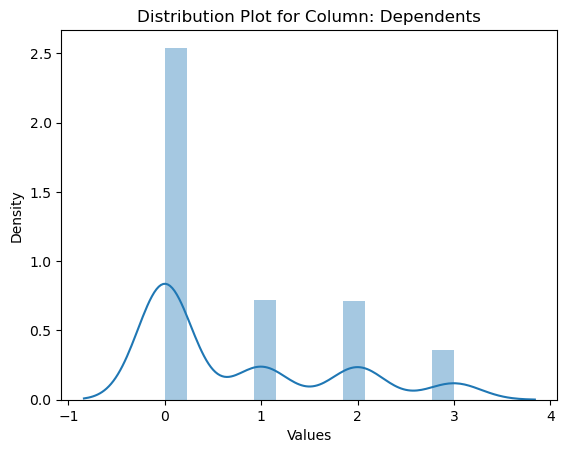

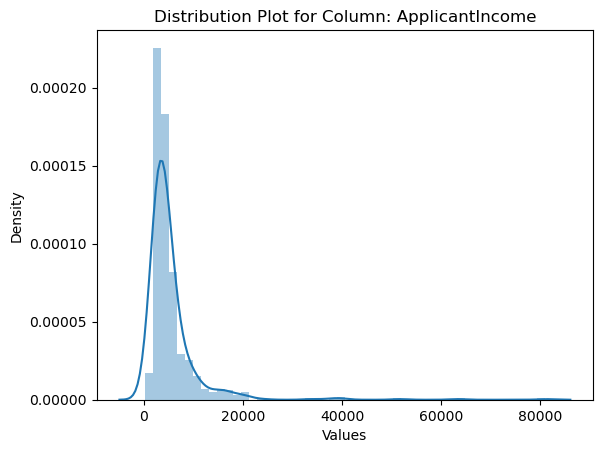

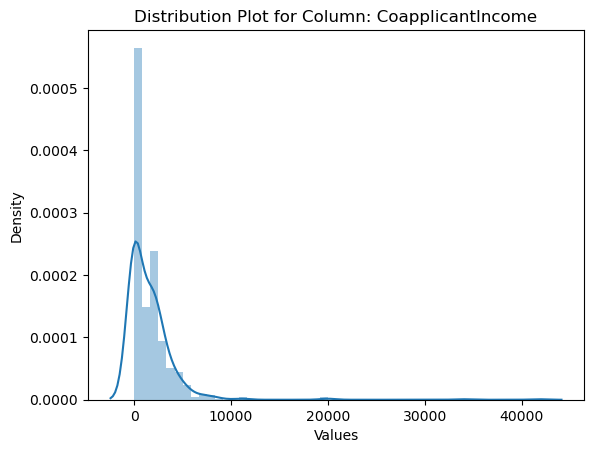

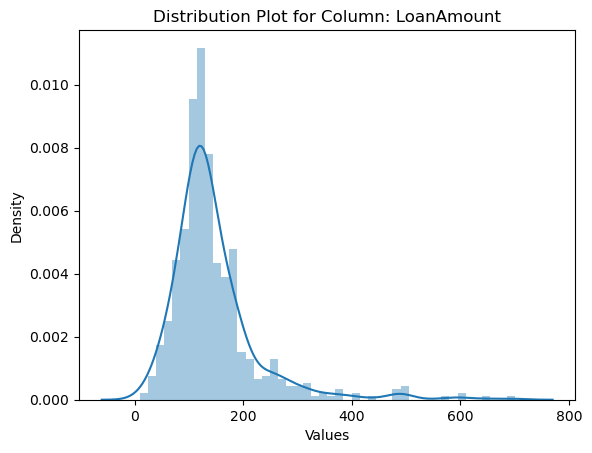

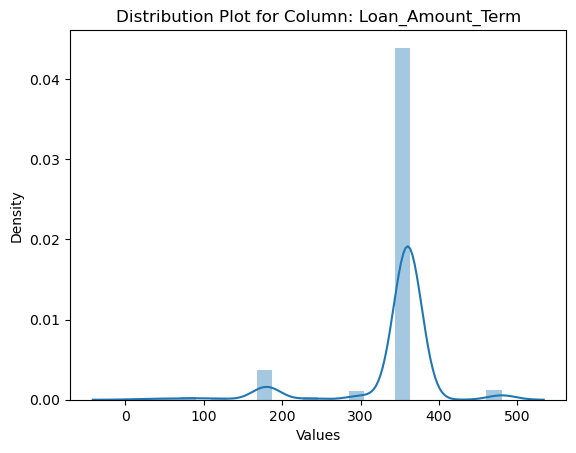

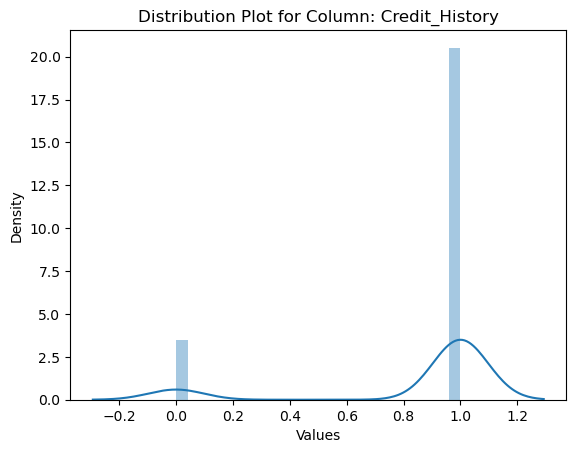

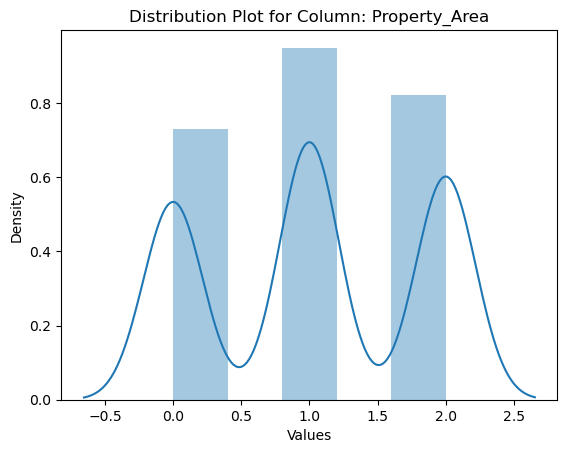

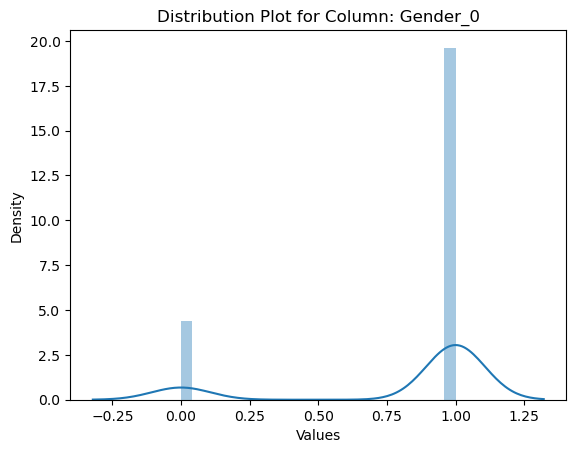

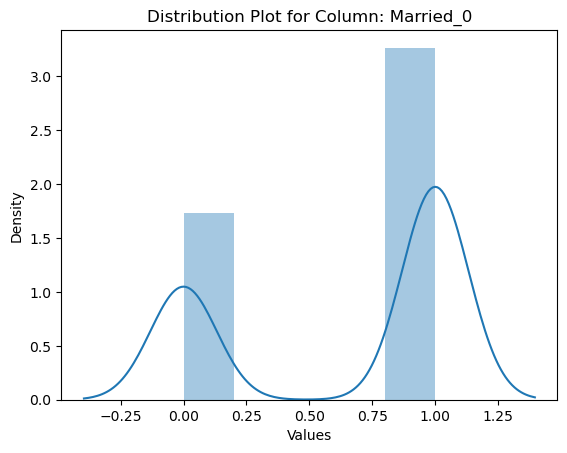

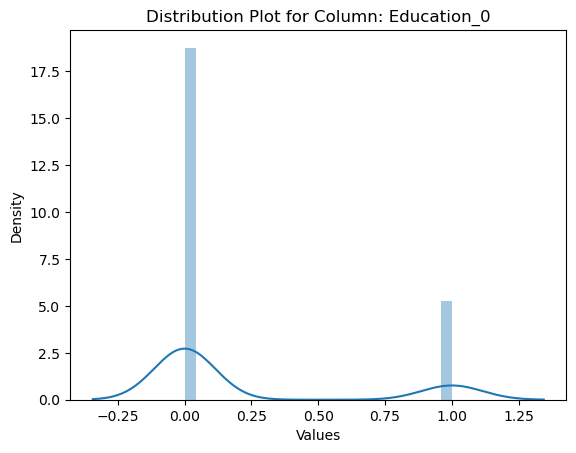

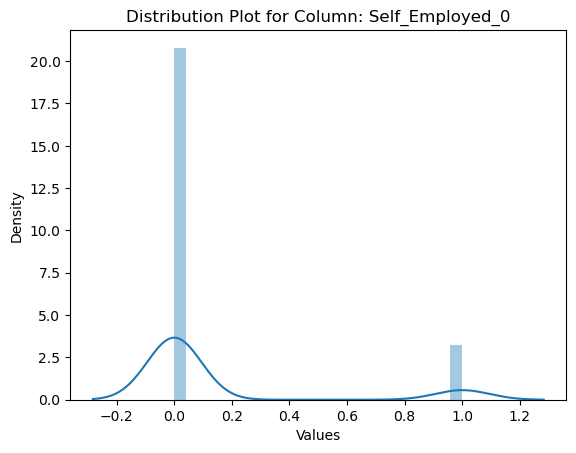

In [30]:
display_distribution_plots(X_train)

# Test Set

# List columns with missing Values and divide by Dtype

In [31]:
find_null_columns(df_test)

['Gender',
 'Dependents',
 'Self_Employed',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [32]:
divide_columns_by_datatype(df_test,find_null_columns(df_test))

(['Gender', 'Dependents', 'Self_Employed'],
 ['LoanAmount', 'Loan_Amount_Term', 'Credit_History'])

## Impute Missing values based on type of missing data(Categorical/Numeric)

In [33]:
obj_test = [ 'Gender','Dependents', 'Self_Employed']
num_test = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']

In [34]:
impute_missing_values(df_test,obj_test,num_test)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,1.0,Urban
4,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...
362,Male,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban
363,Male,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban
364,Male,No,0,Graduate,No,3250,1993,126.0,360.0,1.0,Semiurban
365,Male,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural


# Create a dictionary with Column Name and encoding Type

In [35]:
cols = df_test[['Gender','Married','Education','Self_Employed','Dependents','Property_Area']].columns.tolist()
test_encoding = ['one-hot','one-hot','one-hot','one-hot','ordinal','ordinal']

In [36]:
create_col_encoding_dict(cols,test_encoding)

{'Gender': 'one-hot',
 'Married': 'one-hot',
 'Education': 'one-hot',
 'Self_Employed': 'one-hot',
 'Dependents': 'ordinal',
 'Property_Area': 'ordinal'}

# Encoding the required columns

In [37]:
final_test_df = encode_columns(df_test,create_col_encoding_dict(cols,test_encoding))

In [38]:
final_test_df

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Gender_0,Married_0,Education_0,Self_Employed_0
0,0.0,5720,0,110.0,360.0,1.0,2.0,1.0,1.0,0.0,0.0
1,1.0,3076,1500,126.0,360.0,1.0,2.0,1.0,1.0,0.0,0.0
2,2.0,5000,1800,208.0,360.0,1.0,2.0,1.0,1.0,0.0,0.0
3,2.0,2340,2546,100.0,360.0,1.0,2.0,1.0,1.0,0.0,0.0
4,0.0,3276,0,78.0,360.0,1.0,2.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
362,3.0,4009,1777,113.0,360.0,1.0,2.0,1.0,1.0,1.0,1.0
363,0.0,4158,709,115.0,360.0,1.0,2.0,1.0,1.0,0.0,0.0
364,0.0,3250,1993,126.0,360.0,1.0,1.0,1.0,0.0,0.0,0.0
365,0.0,5000,2393,158.0,360.0,1.0,0.0,1.0,1.0,0.0,0.0


In [39]:
final_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dependents         367 non-null    float64
 1   ApplicantIncome    367 non-null    int64  
 2   CoapplicantIncome  367 non-null    int64  
 3   LoanAmount         367 non-null    float64
 4   Loan_Amount_Term   367 non-null    float64
 5   Credit_History     367 non-null    float64
 6   Property_Area      367 non-null    float64
 7   Gender_0           367 non-null    float64
 8   Married_0          367 non-null    float64
 9   Education_0        367 non-null    float64
 10  Self_Employed_0    367 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 31.7 KB


# Looking at the Distribution of the Features

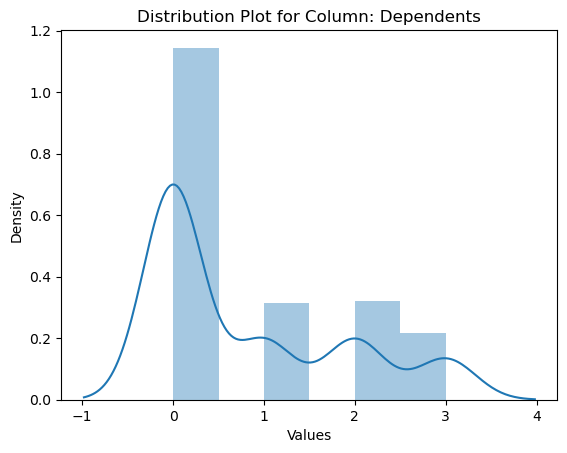

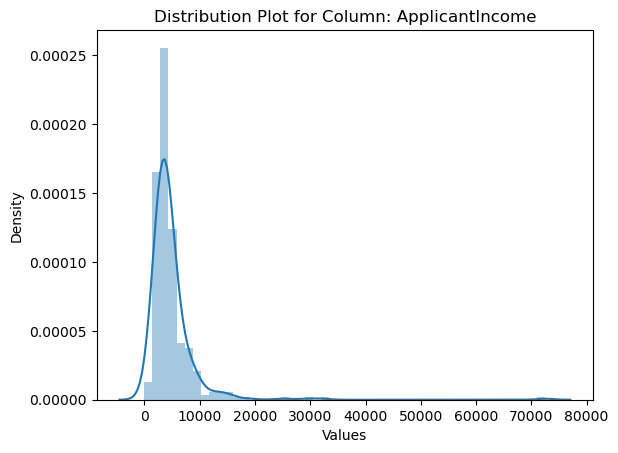

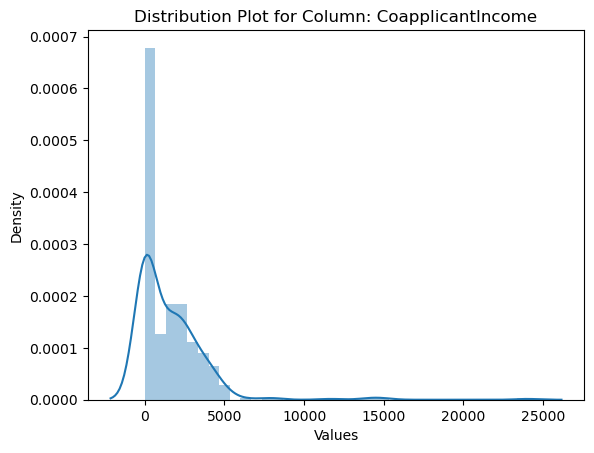

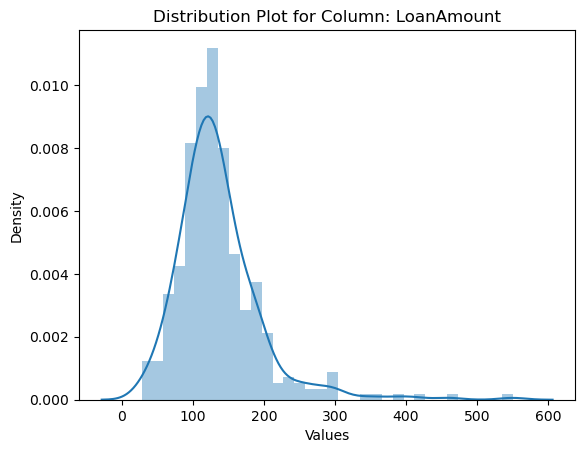

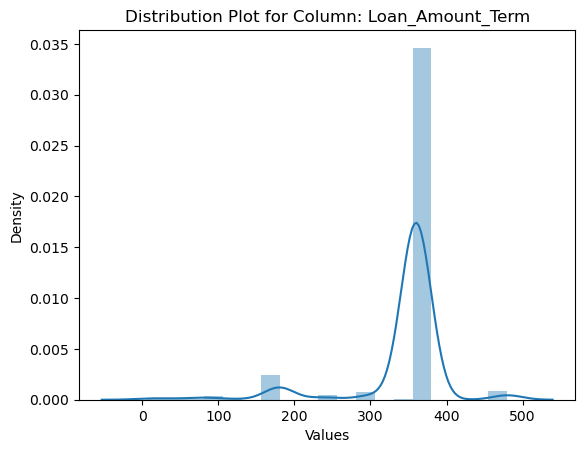

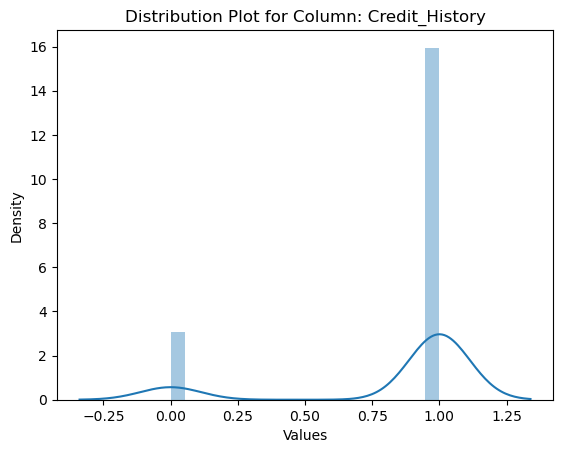

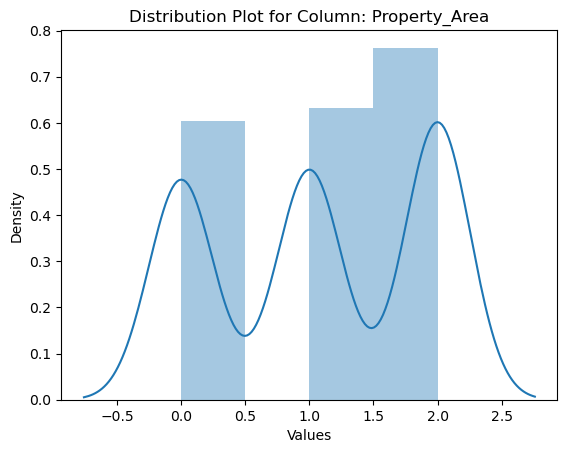

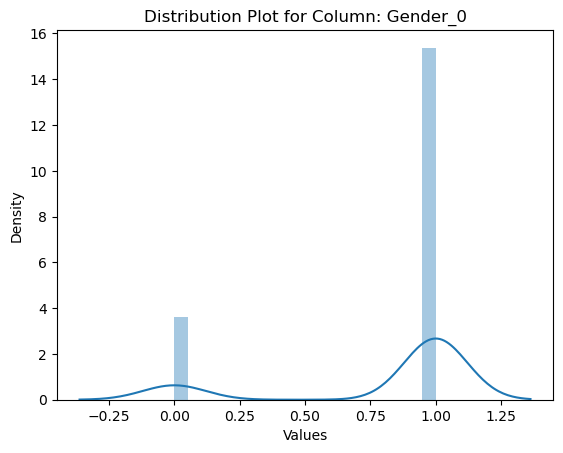

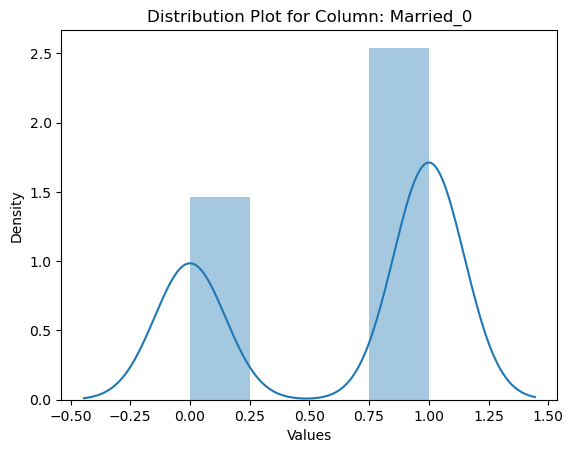

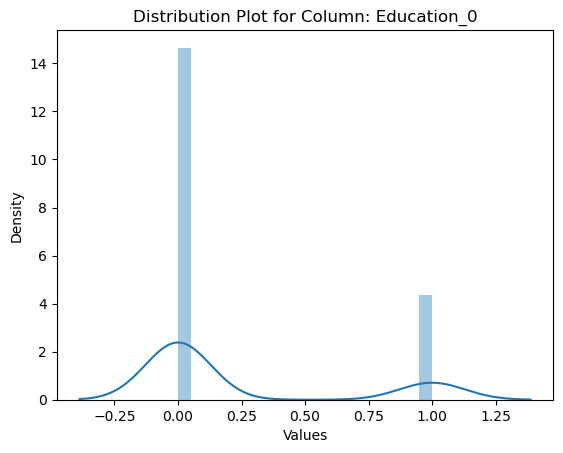

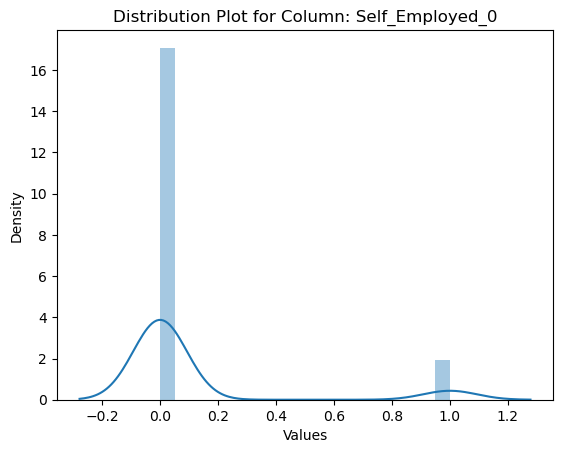

In [40]:
display_distribution_plots(final_test_df)

# Scaling Training data as all ranges are different

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)

In [42]:
X_train

array([[-0.73780632,  0.07299082, -0.55448733, ..., -1.37208932,
        -0.52836225, -0.39260074],
       [ 0.25346957, -0.13441195, -0.03873155, ...,  0.72881553,
        -0.52836225, -0.39260074],
       [-0.73780632, -0.39374734, -0.55448733, ...,  0.72881553,
        -0.52836225,  2.54711697],
       ...,
       [ 0.25346957,  0.43717437, -0.47240418, ...,  0.72881553,
        -0.52836225, -0.39260074],
       [ 1.24474546,  0.35706382, -0.55448733, ...,  0.72881553,
        -0.52836225, -0.39260074],
       [-0.73780632, -0.13441195, -0.55448733, ..., -1.37208932,
        -0.52836225,  2.54711697]])

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2,random_state=1)

In [44]:
#Implement Logistic Regression Model
model=LogisticRegression().fit(X_train,Y_train)

In [45]:
Y_pred = model.predict(X_test)

In [73]:
Y_pred

array(['N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'N',
       'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y'], dtype=object)

Training Accuracy:  0.8065173116089613
Testing Accuracy:  0.8373983739837398
Classification Report:                precision    recall  f1-score   support

           N       1.00      0.47      0.64        38
           Y       0.81      1.00      0.89        85

    accuracy                           0.84       123
   macro avg       0.90      0.74      0.77       123
weighted avg       0.87      0.84      0.82       123

[[18 20]
 [ 0 85]] : Confusion Matrix


<AxesSubplot:>

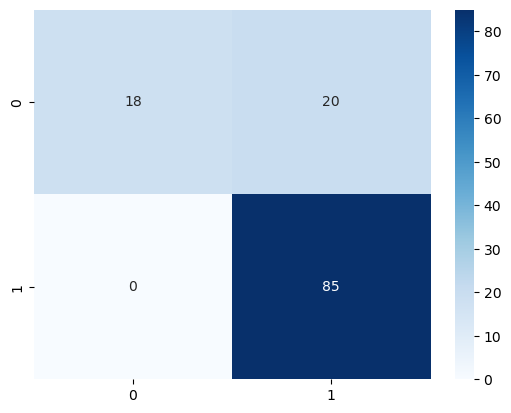

In [46]:
train_acc = accuracy_score(Y_train, model.predict(X_train))
test_acc = accuracy_score(Y_test, Y_pred)
clf_report = classification_report(Y_test, Y_pred)
cm = confusion_matrix(Y_test,Y_pred)

print("Training Accuracy: ", train_acc)
print("Testing Accuracy: ", test_acc)
print("Classification Report: ", clf_report)
print(cm, ": Confusion Matrix")
sns.heatmap(cm, annot=True, cmap="Blues")

In [47]:
test_pred = model.predict(final_test_df)

In [48]:
test_pred.shape

(367,)

In [49]:
final_test_df.shape

(367, 11)

# We cannot find AUC as our FPR is 0

# Our model can predict whether an applicant can be granted a home loan with 83% accuracy.